<a class="anchor" id="0"></a>
# **prediction des troubles musculosquelettiques**

## **Preparation de l'espce de travail**

***importation des packages***

In [2]:
import pandas as pd  # Pandas est utilisé pour la manipulation et l'analyse de données.
import matplotlib.pyplot as plt  # Matplotlib.pyplot permet de créer des graphiques et des visualisations.
import seaborn as sns  # Seaborn est une bibliothèque basée sur Matplotlib pour des graphiques statistiques attractifs.
import numpy as np  # NumPy est utilisé pour le calcul scientifique et supporte des tableaux et matrices multidimensionnels.
import warnings
# Ignorer tous les warnings
warnings.filterwarnings("ignore")
# Votre code qui peut générer des warnings
# ...

***importation des classes***

In [2]:
from sklearn.preprocessing import LabelEncoder
#Les modeles
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.svm import  LinearSVC,SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

***importation des fonctions***

In [3]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import plot_tree, export_text #Visualiser un abre de décision représenté sous forme textuelle
# Fonctions pour évaluer les modèles
from sklearn.metrics import (confusion_matrix,classification_report,accuracy_score,roc_auc_score,recall_score,
                             precision_score,f1_score,cohen_kappa_score,matthews_corrcoef,roc_curve,auc)

from sklearn.preprocessing import StandardScaler  # Fonction pour la normalisation des données

# Fonctions pour la validation croisée et la recherche d'hyperparamètres

from sklearn.model_selection import train_test_split, GridSearchCV 

***défintion des instances***

In [4]:
encoder = LabelEncoder()# Crée une instance de LabelEncoder pour convertir les étiquettes de catégories en valeurs numériques
scaler = StandardScaler()# Créer une instance pour standardiser les variables
# Création des instances des modèles

models={
'lgb': LGBMClassifier(verbose=-1), # Classificateur LightGBM avec sortie de journalisation désactivée
'rfc' : RandomForestClassifier(),  # Classificateur utilisant une forêt d'arbres décisionnels
'gbc' : GradientBoostingClassifier(),  # Classificateur utilisant le boosting par gradient
'etc' : ExtraTreesClassifier(), # Classificateur utilisant des arbres décisionnels extrêmement aléatoires
'adabc': AdaBoostClassifier(),  # Classificateur utilisant le boosting adaptatif
'logit' : LogisticRegression(),  # Régression logistique pour classification binaire ou multiclasse
'rc': RidgeClassifier(), # Classificateur Ridge, une variante de la régression linéaire avec régularisation L2
'lsvc ' : LinearSVC(), # Classificateur à vecteurs de support linéaire
'gnb' : GaussianNB(), # Classificateur Naïve Bayes gaussien
'knc' : KNeighborsClassifier(),  # Classificateur basé sur les k plus proches voisins
'mlpc' : MLPClassifier(),  # Classificateur à perceptron multicouche (réseau de neurones)
'dtc' : DecisionTreeClassifier(),  # Classificateur basé sur un arbre de décision
'dc': DummyClassifier(),  # Classificateur factice pour établir des baselines simples
'qda': QuadraticDiscriminantAnalysis(),  # Analyse discriminante quadratique pour classification
'svm':SVC(kernel='rbf', gamma=1,probability=True)# SVM à noyau gaussien de paramètre gamma=0.01
     }
# Liste des noms des modèles sous forme de chaînes de caractères
# Évaluation de chaque nom de modèle dans la liste pour obtenir les instances correspondantes

***importation des données***

In [5]:
data= pd.read_excel('Base_simplifiée.xlsx')
print(f"Cette base décrit {data.shape[0]} individus sur {data.shape[1]} variables qui sont {list(data.columns)} ")

Cette base décrit 1720 individus sur 16 variables qui sont ['Hopital consulté', 'Sexe', 'Profession', 'Ethnie', 'Age', "Classe d'age", 'Revenu mensuel moyen', 'Antécédent familial de cancer', 'Organe primaire de la maladie cancéreuse', 'Présence de métastases', 'Durée du traitement', 'consommation active de substances psychostimulantes non prescrites médicalement', 'Score total OSLO', 'Classification OSLO', 'Score de dépistage', 'Résultat dépistage'] 


***supprimer des variables redondantes et présentation des données***

In [6]:
df_no_numeric=data.drop(['Score total OSLO','Age','Score de dépistage'],axis=1)
df_no_numeric.shape

(1720, 13)

Après avoir supprimer les variables similiares, ils nous restent 13 variables.

A présent, nous allons transformer les modalitésdes variables en numérique.

In [7]:
# Crée un DataFrame vide
df = pd.DataFrame()
# Boucle sur chaque variable du DataFrame df_no_numeric
for variable in df_no_numeric.columns:
    # Applique LabelEncoder sur chaque variable pour transformer ses modalités en numérique
    # et stocke les résultats transformés dans le DataFrame df
    df[variable] = encoder.fit_transform(df_no_numeric[variable])

#rennoncer une variables de noms très long
df.rename(columns={'consommation active de substances psychostimulantes non prescrites médicalement':'cons active sub psy non prescirtes'}, inplace='True')

#afficher la base
df.head()


,Hopital consulté,Sexe,Profession,Ethnie,Classe d'age,Revenu mensuel moyen,Antécédent familial de cancer,Organe primaire de la maladie cancéreuse,Présence de métastases,Durée du traitement,cons active sub psy non prescirtes,Classification OSLO,Résultat dépistage
0,0,1,4,0,4,0,0,16,1,5,0,2,1
1,0,0,2,0,2,3,1,15,1,5,0,1,0
2,1,0,3,4,2,3,0,8,1,0,0,2,0
3,1,0,3,0,2,3,0,14,1,5,0,0,0
4,1,0,0,4,2,0,0,15,2,5,0,0,1


***Distribution de la variable cible***

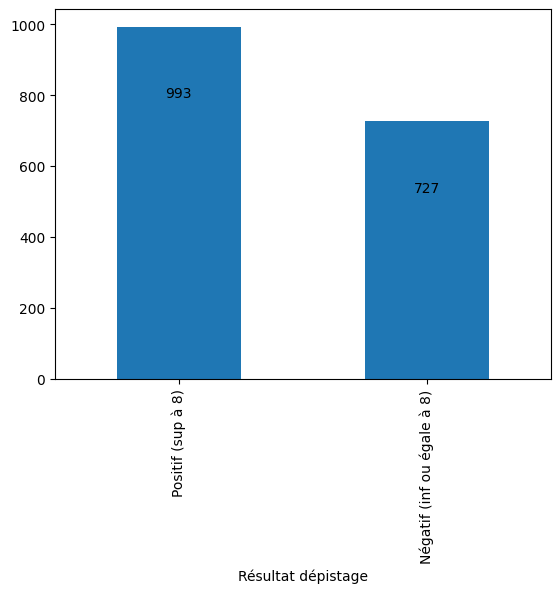

In [8]:
#target variable distribution

frequence=data['Résultat dépistage'].value_counts()
frequence.plot(kind='bar')
for i, nombre in enumerate(frequence):
    plt.text(i,nombre - 200, str(nombre),ha='center')
plt.show()


***Visualisation de la corrélation entre les variables***

In [9]:
# Remplace les noms des colonnes de X par de nouveaux noms.
# La liste de compréhension [f'V{i}' for i in range(1, 12)] crée une liste de
# chaînes de caractères allant de 'V1' à 'V11'. Cela renomme les colonnes de X
# en utilisant cette liste, en commençant par 'V1' pour la première colonne, 'V2'
# pour la deuxième, etc., jusqu'à 'V11' pour la onzième colonne.
df.columns = [f'V{i}' for i in range(1, 14)]
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
0,0,1,4,0,4,0,0,16,1,5,0,2,1
1,0,0,2,0,2,3,1,15,1,5,0,1,0
2,1,0,3,4,2,3,0,8,1,0,0,2,0
3,1,0,3,0,2,3,0,14,1,5,0,0,0
4,1,0,0,4,2,0,0,15,2,5,0,0,1


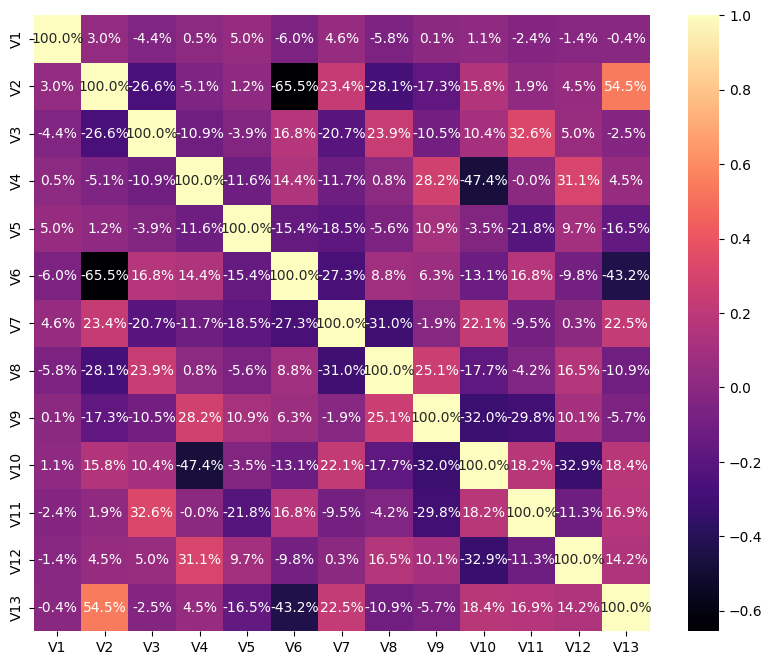

In [10]:
# Visualisation des corrélations entre la variable cible 'charges' et les autres variables
# Calculer la corrélation de la variable 'Résultat dépistage' avec toutes les autres variables et trier les résultats
df.corr()['V13'].sort_values()

# Créer une sous-figure avec une taille spécifiée pour la heatmap
f, ax = plt.subplots(figsize=(10, 8))

# Calculer la matrice de corrélation pour toutes les variables
corr = df.corr()

# Créer une heatmap pour visualiser la matrice de corrélation
# Paramètres :
# - cbar=True : Afficher la barre de couleur
# - square=True : Assurer que la heatmap est de forme carrée
# - fmt='.1%' : Formater les valeurs de corrélation en pourcentages avec une décimale
# - annot=True : Annoter chaque cellule avec la valeur numérique
# - cmap='magma' : Utiliser la colormap 'magma' pour la coloration
sns.heatmap(corr, cbar=True, square=True, fmt='.1%', annot=True, cmap='magma')

# Afficher la heatmap
plt.show()


La variable "Hôpital consulté" montre une très faible corrélation avec le "Résultat dépistage" (valeur de -0.4%). Cette valeur est très proche de zéro, indiquant qu'il n'y a pratiquement aucune relation entre l'hôpital où le patient a été consulté et le résultat du dépistage. En d'autres termes, le choix de l'hôpital consulté n'influence pas de manière significative les résultats du dépistage selon les données représentées dans cette carte thermique.

1. La variable **Sexe (0.545)** présente la corrélation la plus forte : une corrélation positive modérée entre le sexe et le résultat du dépistage. Cela signifie que le sexe de l'individu peut avoir une influence notable sur le résultat du dépistage.

2. Le **Revenu mensuel moyen (-0.432)** a une corrélation négative modérée entre le revenu mensuel moyen et le résultat du dépistage. Cela suggère qu'un revenu plus élevé peut être associé à de moins bons résultats de dépistage ou inversement.

3. L'**Antécédent familial de cancer (0.225)** a une faible corrélation positive entre les antécédents familiaux de cancer et le résultat du dépistage, impliquant que les antécédents familiaux de cancer peuvent être légèrement liés à un meilleur résultat de dépistage.

4. La **Classe d'âge (-0.165)** : a une faible corrélation négative entre la classe d'âge et le résultat du dépistage, indiquant que l'âge peut avoir un effet, bien que léger, sur les résultats de dépistage.

5. La **Classification OSLO (0.142)** a une faible corrélation positive entre la classification OSLO et le résultat du dépistage, ce qui pourrait indiquer une certaine influence de cette classification sur les résultats de dépistage.

6. La **Durée du traitement (0.184)**: a une faible corrélation positive entre la durée du traitement et le résultat du dépistage, ce qui peut suggérer que la durée du traitement pourrait avoir un effet sur les résultats de dépistage.

Les autres variables présentes aussi des corrélations avec la variable dépendante et dans une proportion très faibles.

In [11]:
#supprime la variable hopital consulté
df=df.drop(['V1'],axis=1)

**séparation des variables**

In [12]:
#Remplacer les espaces dans les noms des colonnes
#df.columns = df.columns.str.replace(' ', '_')

In [13]:
# Assigne la colonne 'Résultat_dépistage' du DataFrame df à la variable y,
# qui représentera la variable cible pour les modèles de machine learning.
y = df['V13']  # cible

# Crée un nouveau DataFrame X en supprimant la colonne 'Résultat_dépistage'
# de df. Cela signifie que X contiendra toutes les colonnes sauf 'Résultat_dépistage'.
# X représentera les caractéristiques (features) pour les modèles de machine learning.
X = df.drop(['V13'], axis=1)  # caractéristiques

#standardise les variables prédictrices

X= scaler.fit_transform(X)

**Diviser le jeu de données en ensemble d'entraînement et ensemble de test**

In [14]:
# Vérifier la distribution des classes
# split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)
# Vérifier la distribution des classes
print(f"Distribution des classes dans les données d'entraînement :\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Distribution des classes dans les données textes :\n{pd.Series(y_test).value_counts(normalize=True)}")

Distribution des classes dans les données d'entraînement :
V13
1    0.577035
0    0.422965
Name: proportion, dtype: float64
Distribution des classes dans les données textes :
V13
1    0.578488
0    0.421512
Name: proportion, dtype: float64


***Entraînement et developpement des modeles***

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


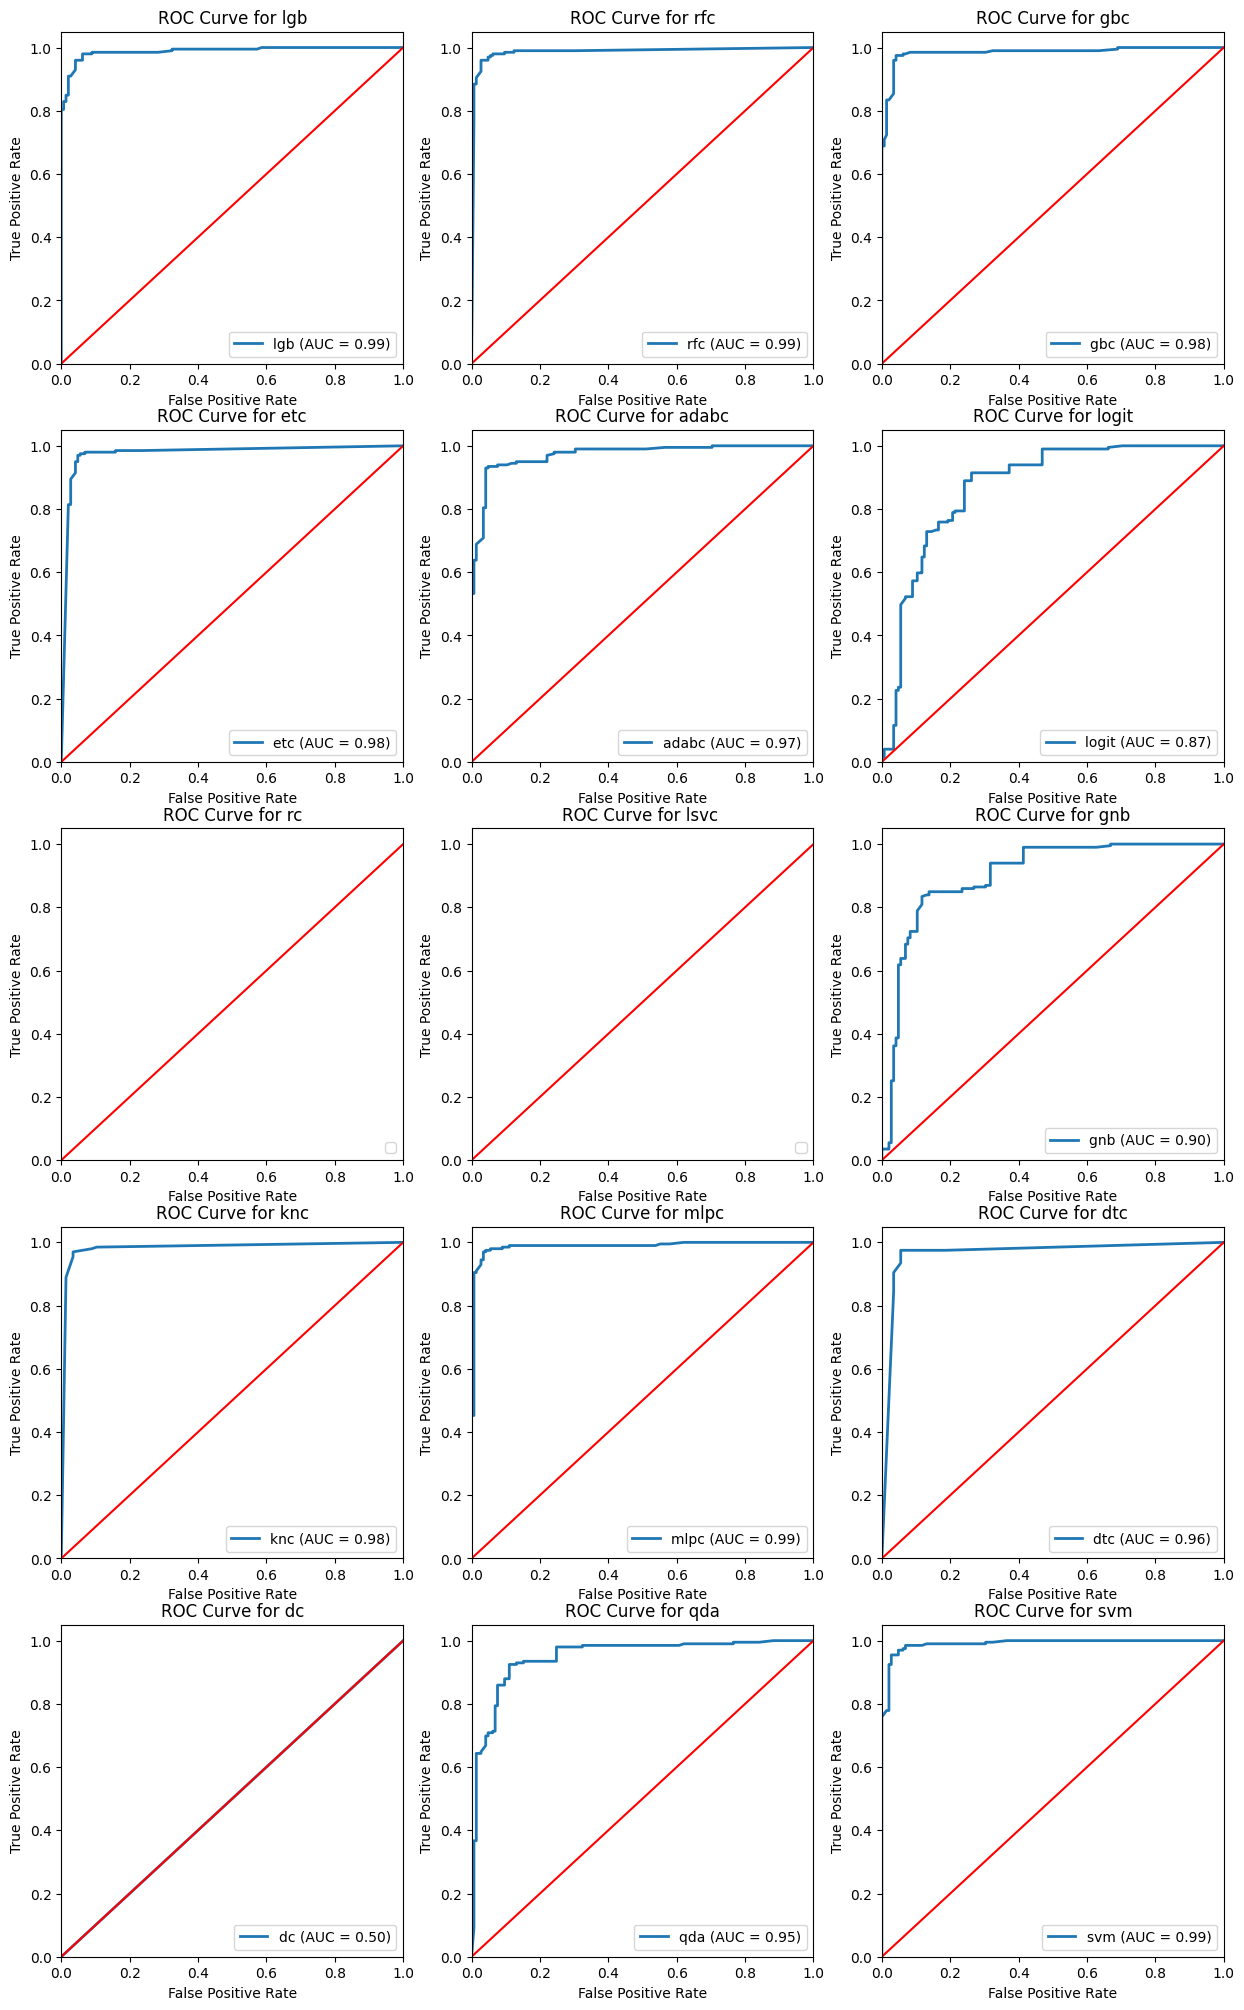

In [15]:
# Initialisation des résultats
results = {
    'Accuracy': [],
    'AUC': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'Kappa': [],
    'MCC': [],
}

predictions = pd.DataFrame()

# Calculer le nombre de lignes nécessaires
num_models = len(models)
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols  # arrondir vers le haut

# Initialisation des sousgraphiques
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Entraînement et évaluation des modèles
for i, (name, model) in enumerate(models.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col] if num_rows > 1 else axs[col]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[f'{name}'] = y_pred
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['AUC'].append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['F1'].append(f1_score(y_test, y_pred))
    results['Kappa'].append(cohen_kappa_score(y_test, y_pred))
    results['MCC'].append(matthews_corrcoef(y_test, y_pred))
    
    # Tracer la courbe ROC
    ax.plot([0, 1], [0, 1], color='red', linestyle='-')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {name}')
    ax.legend(loc="lower right")
# Création du DataFrame des résultats
df_results = pd.DataFrame(results, index=models.keys())

In [16]:
#afficher les metrics d'évaluation
df_results

,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC
lgb,0.956395,0.988598,0.969849,0.955446,0.962594,0.910336,0.910482
rfc,0.959302,0.986138,0.974874,0.955665,0.965174,0.916235,0.916497
gbc,0.968023,0.984301,0.974874,0.970000,0.972431,0.934369,0.934386
etc,0.962209,0.975516,0.974874,0.960396,0.967581,0.922291,0.922439
adabc,0.930233,0.971669,0.934673,0.944162,0.939394,0.857207,0.857268
logit,0.787791,0.871391,0.758794,0.857955,0.805333,0.574026,0.579267
rc,0.796512,NaN,0.758794,0.872832,0.811828,0.592651,0.599554
lsvc,0.787791,NaN,0.758794,0.857955,0.805333,0.574026,0.579267
gnb,0.840116,0.901854,0.849246,0.871134,0.860051,0.673681,0.673977
knc,0.968023,0.982343,0.969849,0.974747,0.972292,0.934492,0.934509


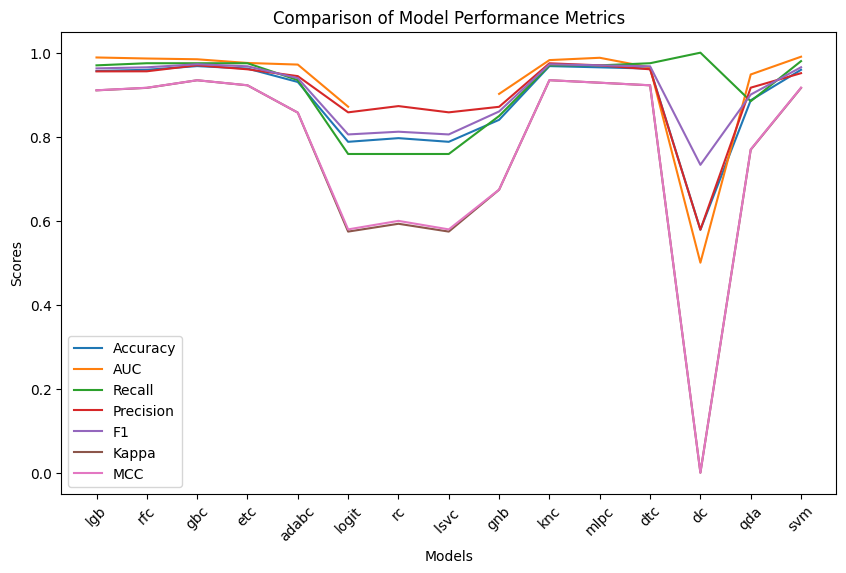

In [17]:
# Tracé du graphique 
plt.figure(figsize=(10, 6))
for metric in df_results.columns:
    plt.plot(df_results.index, df_results[metric], label=metric)
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()
plt.title('Comparison of Model Performance Metrics')
plt.show()

## **Confusion-matrix**

In [18]:
predict=np.array(predictions)
CM={}
for i in range(len(predictions.columns)):
    cm = confusion_matrix(y_test,predictions.iloc[:,i])
    CM[f'{predictions.columns[i]}']=cm

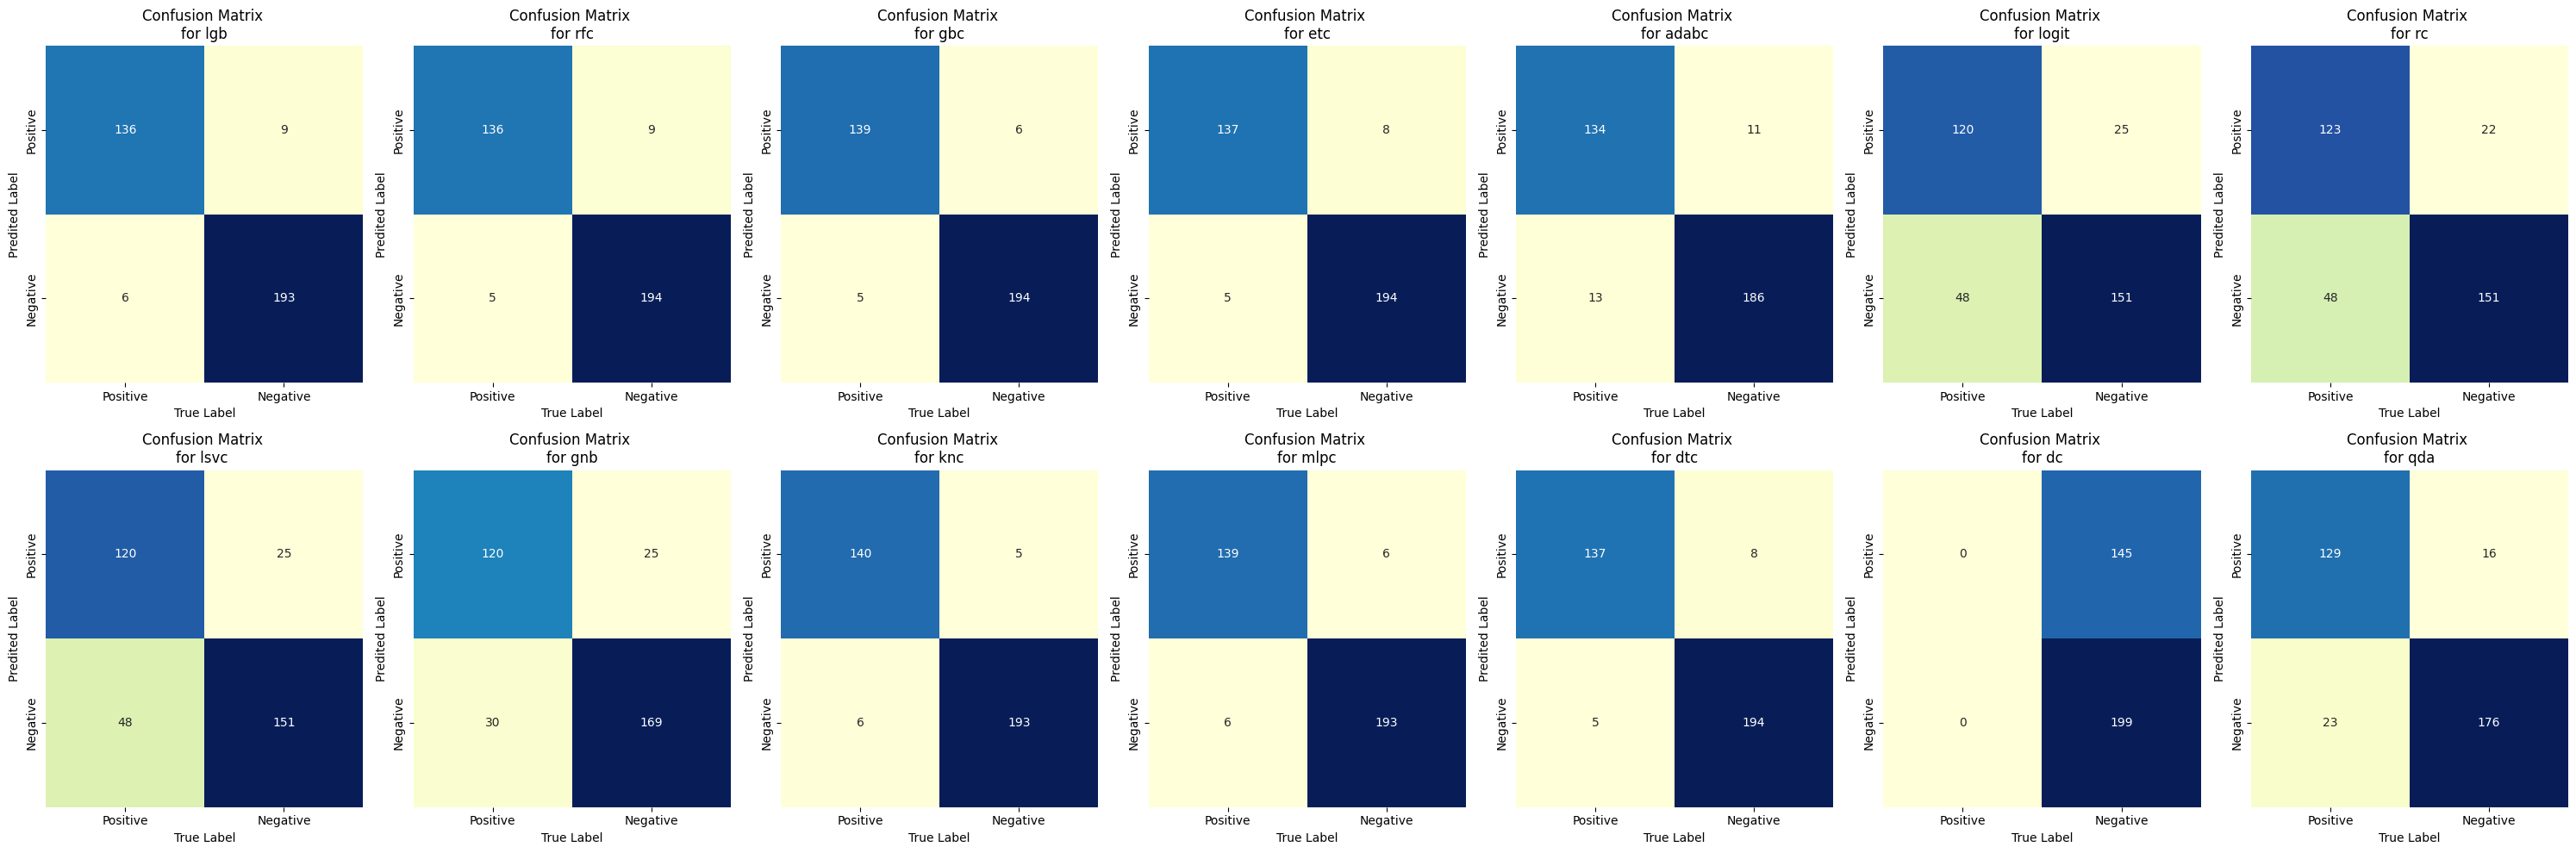

In [20]:
# Création des sous-graphes pour afficher les matrices de confusion
fig, axes = plt.subplots(2,7, figsize=(30, 10))

# Itération sur les modèles et leurs matrices de confusion
for ax, (model_name, cm) in zip(axes.flatten(), CM.items()):
    cm_matrix = pd.DataFrame(data=cm, columns=['Positive', 'Negative'], 
                             index=['Positive', 'Negative'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix \nfor {model_name}')
    ax.set_ylabel('Predited Label')
    ax.set_xlabel('True Label')

# Ajustement de la disposition pour éviter le chevauchement des sous-graphes
plt.tight_layout()
plt.show()
#plt.savefig('matrice_de_confusion.png')


#### Observations générales

1. A partir du tableau des métriques d'évaluation, des graphiques de la courbe ROC des différents modeles et le graphique des métriques, on remarque que les modèles Ridge Classifier (RC) et LinearSupportVectionClassifier (lsvc) n'affichent pas de métriques AUC. Ce qui a rendu leurs courbes ROC vides et a entraîné un saut de la courbe de l'AUC sur le graphique de performances. En effet, ni `LinearSVC` ni `RidgeClassifier` n'ont la méthode `predict_proba` et ne peuvent donc pas fournir les probabilités de prédctions des classes. Cependant,on peut utiliser `SVC` avec le paramètre `probability=True`. Cela permet d'activer un ajustement basé sur la probabilité par validation croisée interne, mais cela rend l'entraînement du modèle plus lent. Dans le cas de `RidgeClassifier`, il n'y a pas de méthode directe pour calculer les probabilités. Il fournit seulement des prédictions de classe. Il y a deux alternatives pour le faire : la 1ère est d'utiliser `CalibratedClassifierCV` pour calibrer les scores de décision du RidgeClassifier et obtenir des probabilités. La deuxième consiste à ajuster une fonction sigmoïde sur les scores de décision pour approximer les probabilités. Nous n'allons utiliser ces approches pour l'instant. Nous utilisons si et seulement si au moins un de ces models révèle de meilleures performances en se basant sur les métriques restantes.

2. L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets choisis au hasard, un malade et un non-malade, la valeur du marqueur soit plus élevée pour le malade que pour le non-malade. Par conséquent, une AUC de 0,5 (50%) indique que le marqueur est non-informatif. Une augmentation de l'AUC indique une amélioration des capacités discriminatoires, avec un maximum de 1,0 (100%) <br> <br> https://www.idbc.fr/tutoriel-comment-lire-une-courbe-roc-et-interpreter-son-auc/#:~:<br> <br> Les courbes ROC (Receiver Operating Characteristic) et les valeurs de l'AUC (Area Under the Curve) pour différents modèles montrent que les models `lgb, rfc, gbc, etc, knn, mlpc, dtc, adabc,svm` présentent de bonnes performances.La courbe est très proche du coin supérieur gauche, indiquant un taux élevé de vrais positifs et un taux faible de faux positifs. Le reste des models présente des performances inférieures aux models précédents. <br>En se basant sur la courbe ROC les models de **Meilleures performances** sont : `lgb, rfc, gbc, etc, knc, mlpc, dtc,svm` (AUC ≈ 0.97-0.99). Ces modèles se comportent généralement mieux que les modèles simples comme la régression logistique ou Naive Bayes. Le Dummy Classifier et le Ridge Classifier montrent des performances très médiocres, ne discriminant pas mieux que le hasard. le Dummy Classifier(AUC=0,5) sans pouvoir discriminant, équivalent à une classification aléatoire.

3. Le tableau d'évaluation des models ainsi que le graphique des métriques nous permettent d'analyser la performance des différents models au vue des autres métriques. En effet, les modeles `lgb,rfc, gbc, etc,mlpc,svm,dtc,knc ` présentent des performances globales élevées sur toutes les métriques, ce qui indique un bon équilibre entre précision et rappel. Les modeles `adabc,logit,rc, lsvc,gnb,qda`  ont une baisse notable des scores, en particulier pour Recall, MCC et Kappa.

***comparaison des accuracy sur les données test avec ceux des données d'entraînement***

In [61]:
# Créer un DataFrame vide pour stocker les scores
scores_df = pd.DataFrame(columns=['Modèle', 'Score Entraînement', 'Score Test'])

# Calcul des scores et ajout au DataFrame
for name, model in models.items():
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    # Ajouter une nouvelle ligne au DataFrame avec les scores
    scores_df = pd.concat([scores_df, pd.DataFrame({
        'Modèle': [name],
        'Score Entraînement': [train_score],
        'Score Test': [test_score]
    })], ignore_index=True)

# Afficher le DataFrame
print(scores_df)

   Modèle  Score Entraînement  Score Test
0     lgb            0.986192    0.956395
1     rfc            0.986192    0.959302
2     gbc            0.981105    0.968023
3     etc            0.986192    0.959302
4   adabc            0.954942    0.930233
5   logit            0.796512    0.787791
6      rc            0.803052    0.796512
7   lsvc             0.796512    0.787791
8     gnb            0.851017    0.840116
9     knc            0.972384    0.968023
10   mlpc            0.979651    0.968023
11    dtc            0.986192    0.959302
12     dc            0.577035    0.578488
13    qda            0.918605    0.886628
14    svm            0.984738    0.959302


### 1. **Scores d'Entraînement et de Test :**

- **Score d'Entraînement** : La performance du modèle sur les données d'entraînement.
- **Score de Test** : La performance du modèle sur les données de test, qui sont des données non vues par le modèle pendant l'entraînement.

### 2. **Interprétation des Résultats :**

Des 8 modèles jugés plus performant précédemment, on remarque que:

- **`lgb, rfc, etc, gbc, dtc, svm`** montrent des scores d'entraînement élevés, proches de 0.98, et des scores de test également élevés (autour de 0.96 à 0.97). Cela indique que ces modèles sont performants à la fois sur les données d'entraînement et de test, et qu'ils généralisent bien aux nouvelles données.

-Les deux autres restants **`knc, mlpc`** ont de bons scores de test (0.97 pour knc et 0.96 pour mlpc) mais leurs scores d'entraînement sont légèrement plus élevés. Cela pourrait suggérer que ces modèles sont également performants et généralisent bien aux données de test.
Les autres modèles avec un écart plus important entre les scores d'entraînement et de test pourraient être sujets à un surapprentissage, comme `adabc` et `qda`.

Dans la suite nous allons optimiser les 8 modèles candidats et continuez l'évaluation.


In [62]:

# Création d'un nouveau dictionnaire avec uniquement les modèles à conserver
filtered_models = {name: model for name, model in models.items() if name in ['lgb', 'rfc', 'gbc', 'etc', 'knc', 'mlpc', 'dtc','svm']}

# Affichage du dictionnaire filtré
print(filtered_models)

{'lgb': LGBMClassifier(verbose=-1), 'rfc': RandomForestClassifier(), 'gbc': GradientBoostingClassifier(), 'etc': ExtraTreesClassifier(), 'knc': KNeighborsClassifier(), 'mlpc': MLPClassifier(), 'dtc': DecisionTreeClassifier(), 'svm': SVC(gamma=1, probability=True)}


In [63]:
# Initialisation des résultats
results = {
    'Accuracy': [],
    'AUC': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'Kappa': [],
    'MCC': [],
}
# Grilles de paramètres pour chaque modèle
param_grids = {
    'lgb': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'num_leaves': [31, 61, None]},
    'rfc': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]},
    'gbc': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'etc': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]},
    'knc': {'n_neighbors': [3, 5, 7, 9]},
    'mlpc': {'hidden_layer_sizes': [(10,), (50,), (100,)], 'alpha': [0.01, 0.1, 1]},
    'dtc': {'max_depth': [5, 10, None]},
    'svm': {'C': [0.01, 1, 100], 'gamma': [0.01, 0.1, 1]}
}

# Dictionnaire pour stocker les meilleurs résultats
best_models = {}

# Optimisation des modèles
for name, model in filtered_models.items():    
    # Créez l'objet GridSearchCV avec les paramètres spécifiques au modèle
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='accuracy')
    
    # Entraînez GridSearchCV sur les données d'entraînement
    grid_search.fit(X_train, y_train)
    
    # Stockez le meilleur modèle et ses paramètres
    best_models[name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'score': grid_search.best_score_
    }
    

# Entraînement et évaluation des meilleurs modèles
for name, model_info in best_models.items():
    model = model_info['model']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['AUC'].append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['F1'].append(f1_score(y_test, y_pred))
    results['Kappa'].append(cohen_kappa_score(y_test, y_pred))
    results['MCC'].append(matthews_corrcoef(y_test, y_pred))

In [64]:
df_results=pd.DataFrame(results, index=filtered_models.keys())
df_results

,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC
lgb,0.962209,0.985860,0.974874,0.960396,0.967581,0.922291,0.922439
rfc,0.959302,0.986068,0.974874,0.955665,0.965174,0.916235,0.916497
gbc,0.962209,0.978635,0.979899,0.955882,0.967742,0.922145,0.922559
etc,0.962209,0.972882,0.974874,0.960396,0.967581,0.922291,0.922439
knc,0.956395,0.981008,0.959799,0.964646,0.962217,0.910671,0.910687
mlpc,0.968023,0.985444,0.974874,0.970000,0.972431,0.934369,0.934386
dtc,0.959302,0.960908,0.974874,0.955665,0.965174,0.916235,0.916497
svm,0.968023,0.972518,0.979899,0.965347,0.972569,0.934246,0.934396


Pour interpréter le tableau de performances des modèles de classification, nous devons examiner plusieurs métriques afin de déterminer quel modèle est le plus performant. Voici une brève explication des principales métriques utilisées :

1. **Accuracy** : Proportion de prédictions correctes parmi toutes les prédictions.
2. **AUC (Area Under the Curve)** : Aire sous la courbe ROC, mesure de la capacité du modèle à distinguer entre les classes positives et négatives.
3. **Recall** : Capacité du modèle à identifier toutes les instances positives (aussi appelé sensibilité ou taux de vrais positifs).
4. **Precision** : Proportion des prédictions positives correctes parmi toutes les prédictions positives.
5. **F1 Score** : Moyenne harmonique de la précision et du rappel, utile lorsque les classes sont déséquilibrées.
6. **Kappa** : Mesure de l'accord entre les prédictions et les valeurs réelles, corrigée pour l'accord attendu par hasard.
7. **MCC (Matthews Correlation Coefficient)** : Mesure de la qualité des classifications binaires (valeurs entre -1 et 1).

Pour choisir le meilleur modèle, il est crucial de considérer plusieurs métriques :

1. Les modèles mlpc et svm ont les meilleures valeurs d'accuracy (0.968023), indiquant qu'ils ont globalement bien prédit les classes.

2. Le modèle rfc a la meilleure AUC (0.986068), suggérant qu'il est le plus performant pour distinguer les classes positives des négatives.

3. Les modèles gbc et svm ont le meilleur rappel (0.979899), indiquant qu'ils ont le mieux capturé les vrais positifs.

4. Le modèle mlpc a la meilleure précision (0.970000), ce qui signifie qu'il minimise les faux positifs.

5. Le modèle svm a le meilleur F1-score (0.972569), indiquant un bon équilibre entre précision et rappel.

6. Le modèle mlpc a le meilleur Kappa (0.934369), indiquant un accord fort au-delà du hasard.

7. Les modèles mlpc et svm ont les meilleurs MCC (0.934386 pour mlpc et 0.934396 pour svm), suggérant qu'ils ont une bonne performance globale.

En conclusion, les modèles mlpc et svm sont constamment parmi les meilleurs pour plusieurs métriques importantes, notamment l'accuracy, la précision, le F1-score, le Kappa, et le MCC.

### Recommandation
Si l'objectif est un bon équilibre global entre les différentes métriques (précision, rappel, F1, MCC), le modèle SVM semble être le meilleur choix.
Si la priorité est donnée à la précision des prédictions positives et à un bon accord au-delà du hasard, le modèle MLPC est également un excellent candidat.

In [65]:
filtered_models['mlpc']

MLPClassifier()

# **Optimization of the Best Model**

## **MLPClassifier**

In [73]:
# Initialisation des résultats
results = {
    'Accuracy': [],
    'AUC': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'Kappa': [],
    'MCC': []}
# Grilles de paramètres pour chaque modèle
param_grids ={'hidden_layer_sizes': [(100,),(50, 50),(150, 100, 50),(100, 100, 100)], 'alpha': [0.01, 0.1, 1,0.0001, 0.001, 0.01]}
# Dictionnaire pour stocker les meilleurs résultats

grid_search = GridSearchCV(estimator=filtered_models['mlpc'], param_grid=param_grids, cv=5, scoring='roc_auc')
    
 # Entraînez GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

print("The optimal parameters are {} with a accuracy of {:.4f}".format(grid_search.best_params_, grid_search.best_score_))

model=grid_search.best_estimator_
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
results['Accuracy'].append(accuracy_score(y_test, y_pred))
results['AUC'].append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
results['Recall'].append(recall_score(y_test, y_pred))
results['Precision'].append(precision_score(y_test, y_pred))
results['F1'].append(f1_score(y_test, y_pred))
results['Kappa'].append(cohen_kappa_score(y_test, y_pred))
results['MCC'].append(matthews_corrcoef(y_test, y_pred))
print(results)

The optimal parameters are {'alpha': 0.01, 'hidden_layer_sizes': (100,)} with a accuracy of 0.9863
{'Accuracy': [0.9709302325581395], 'AUC': [0.9849939351932073], 'Recall': [0.9798994974874372], 'Precision': [0.9701492537313433], 'F1': [0.975], 'Kappa': [0.9402798513940488], 'MCC': [0.9403469286604478]}


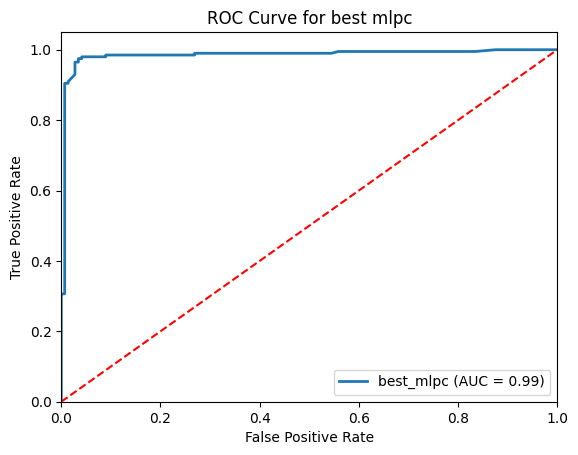

In [74]:
#Courbe ROC
#taux de faux positifs et taux de vrais positifs
fpr, tpr, _ = roc_curve(y_test, y_prob)

#Afficher la courbe
fig,ax=plt.subplots()
ax.plot(fpr, tpr, lw=2, label=f'best_mlpc (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve for best mlpc')
ax.legend(loc="lower right")
plt.show()

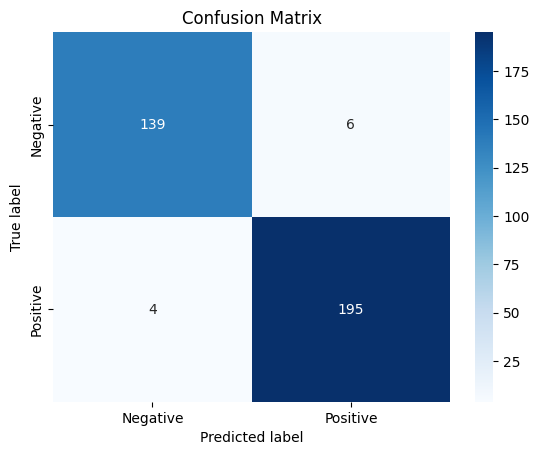

In [4]:
# Afficher la matrice de confusion
conf_matrix =confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## **SVC rbf kernel**

In [69]:
#del results
results = {
    'Accuracy': [],
    'AUC': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'Kappa': [],
    'MCC': []}
#Nous effectuons une validation croisée
# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres'
param_grid = {'C': C_range, 'gamma': gamma_range}

# critère de sélection du meilleur modèle

# initialiser une recherche sur grille
grid =GridSearchCV(SVC(probability=True),
                    param_grid,
                    cv=5, # 5 folds de validation croisée
                    scoring='accuracy')

# faire tourner la recherche sur grille
grid.fit(X_train, y_train)

# afficher les paramètres optimaux
print("The optimal parameters are {} with a accuracy of {:.4f}".format(grid.best_params_, grid.best_score_))
model=grid.best_estimator_
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
results['Accuracy'].append(accuracy_score(y_test, y_pred))
results['AUC'].append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
results['Recall'].append(recall_score(y_test, y_pred))
results['Precision'].append(precision_score(y_test, y_pred))
results['F1'].append(f1_score(y_test, y_pred))
results['Kappa'].append(cohen_kappa_score(y_test, y_pred))
results['MCC'].append(matthews_corrcoef(y_test, y_pred))
print(results)

The optimal parameters are {'C': 10.0, 'gamma': 0.1} with a accuracy of 0.9724
{'Accuracy': [0.9680232558139535], 'AUC': [0.9747010916652227], 'Recall': [0.9748743718592965], 'Precision': [0.97], 'F1': [0.9724310776942355], 'Kappa': [0.9343693631191897], 'MCC': [0.9343859944903832]}


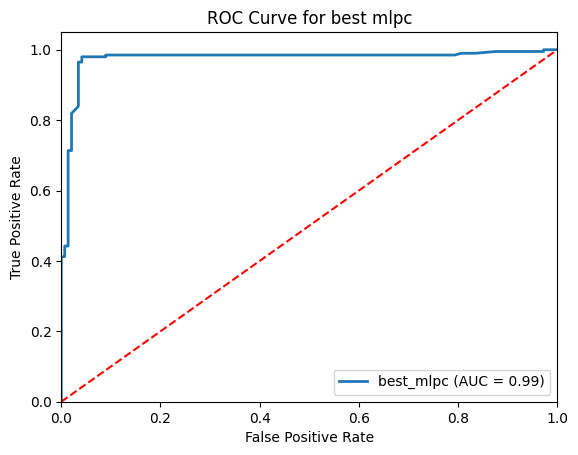

In [70]:
#Courbe ROC
#taux de faux positifs et taux de vrais positifs
fpr, tpr, _ = roc_curve(y_test, y_prob)

#Afficher la courbe
fig,ax=plt.subplots()
ax.plot(fpr, tpr, lw=2, label=f'best_mlpc (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve for best mlpc')
ax.legend(loc="lower right")
plt.show()

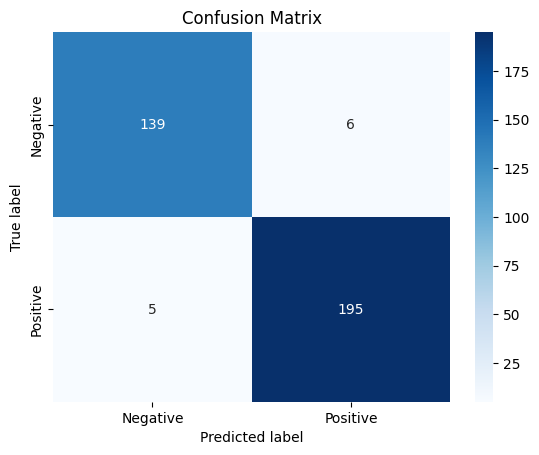

In [5]:
# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### **Retour sur les modèlels**


Le modèle `MLPClassifier` (Multilayer Perceptron Classifier) est une implémentation de réseaux de neurones artificiels pour les tâches de classification dans la bibliothèque `scikit-learn` de Python. Il appartient à la famille des perceptrons multicouches, une forme de réseau de neurones feedforward. Elle est un modèle puissant pour la classification, capable d'apprendre des représentations complexes grâce à ses couches cachées et ses fonctions d'activation non linéaires. Il utilise la rétropropagation pour ajuster les poids et améliorer ses performances sur les tâches de classification.

Le modèle `SVC` (Support Vector Classifier) est une implémentation de la méthode des machines à vecteurs de support (Support Vector Machines ou SVM) dans la bibliothèque `scikit-learn` de Python. Les SVM sont des modèles de machine learning supervisés utilisés principalement pour les tâches de classification. Il cherche à trouver un hyperplan qui sépare les différentes classes dans l'espace des caractéristiques avec la plus grande marge possible. Pour les données non linéaires, il utilise des noyaux pour transformer les données dans un espace de dimensions supérieures où elles deviennent linéairement séparables. Les hyperparamètres tels que `C`, `kernel`, et `gamma` jouent un rôle crucial dans le contrôle de la complexité du modèle et dans l'amélioration des performances de classification.

***Ce qui est important à retenir est que le problème de classification des individus n'est pas un problème linéaire. Ce qui est à la base de la diminution des performances des autres modèles sur certains métriques.***